# Ex12-프로젝트 - Movielens 영화 SBR

## ✅목차
--------------
### Step 1. 데이터의 전처리 
### Step 2. 미니 배치의 구성
### Step 3. 모델 구성
### Step 4. 모델 학습
### Step 5. 모델 테스트

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


## Step 1. 데이터의 전처리

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique() ,data['Time'].nunique()

(6040, 3706, 458455)

### 1.1 Session Length

In [4]:
# 각 세션이 대략 몇 개의 클릭 데이터를 갖는지 살펴보기
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [6]:
session_length.min(), session_length.max()

(20, 2314)

In [7]:
# quantile = 소득구간, 변위치 등 구간을 나타내는 개념
# parameter = 0.999 이면 전체 데이터의 0.999%를 확인할 수 있음
session_length.quantile(0.999)

1343.181000000005

In [8]:
# 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

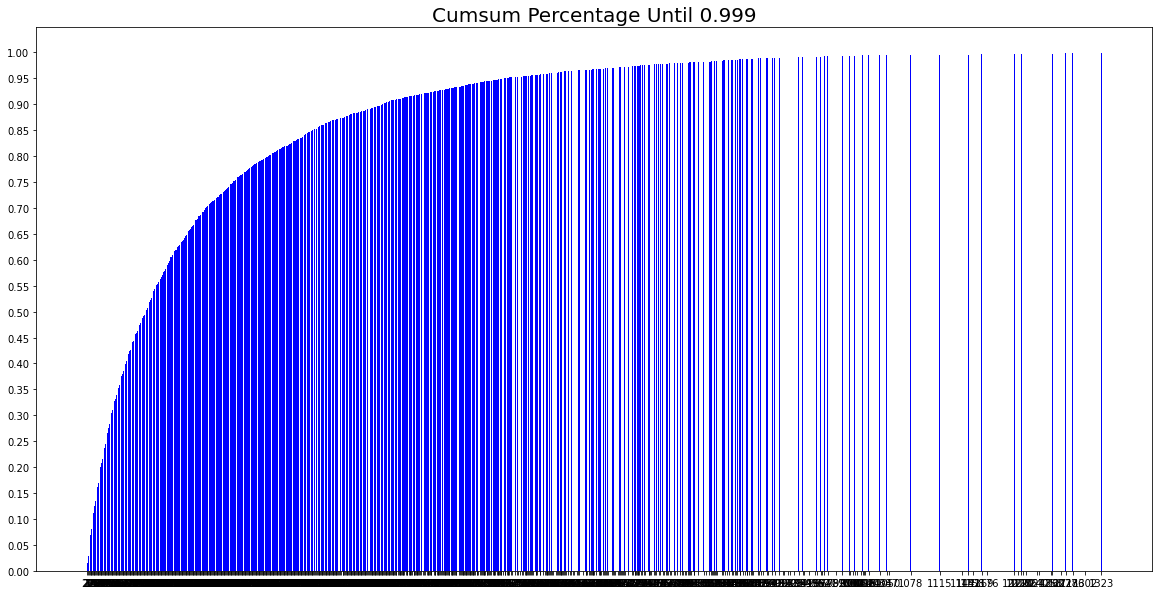

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 1.2 Session Time

In [10]:
from datetime import datetime

change_date = []
for time in data['Time']:
    temp = dt.datetime.fromtimestamp(time)
    change_date.append(temp)

data['Time'] = change_date
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [11]:
# 데이터의 시간 관련 정보를 확인
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


영화추천이기때문에 사용자의 평가인 rating도 중요하다

<AxesSubplot:xlabel='Rating', ylabel='Density'>

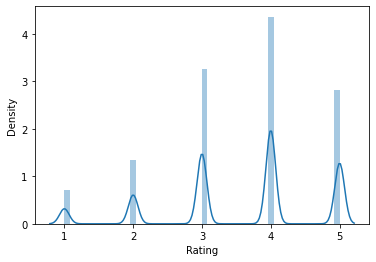

In [12]:
import seaborn as sns
sns.distplot(data['Rating'])

In [13]:
# 위에 그래프를 보면 1,2점이 적기 때문에 3점 이상만 
rate = data[data['Rating']>=3]
rate

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [14]:
data[data['Rating']>=3]

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [15]:
data = data[data['Rating']>=3]
len(data)

836478

### 1.3 Data Cleansing

In [16]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [17]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


## Step 2. 미니 배치의 구성

train, valid, test split하기    

Session-Based Recommendation이기 때문에 기간에 따라 셋을 구성

In [18]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    return before_date, after_date

34개월의 데이터이기 때문에, n_days를 3개월로 두기

In [19]:
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [20]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [21]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 828507
	 Sessions: 6037
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 04:20:59

* valid Set Stats Info
	 Events: 3537
	 Sessions: 228
	 Items: 1540
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 3745
	 Sessions: 230
	 Items: 1558
	 First Time : 2002-11-30 20:24:52
	 Last Time : 2003-02-28 17:49:50



In [22]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱하기
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해주기
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [23]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 3. 모델 구성

In [24]:
# 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  

    def get_click_offsets(self):
       
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [25]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [26]:
tr_dataset.click_offsets

array([     0,     53,    169, ..., 828112, 828231, 828507], dtype=int32)

In [27]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6034, 6035, 6036])

### SessionDataLoader

In [28]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""
    
    # __iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield
    def __init__(self, dataset: SessionDataset, batch_size=32):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """
        # mask는 후에 RNN Cell State를 초기화 하는데 사용
        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인하기
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져오기
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해두기
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져오기
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져오기
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것임
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update함
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더함
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻. mask에 기록해줌

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것 이다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록하기
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록하기
        return start, end, mask, last_session, finished

In [29]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [30]:
iter_ex = iter(tr_data_loader)

In [31]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


### Evaluation Metric

In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [45]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [53]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k


In [105]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [106]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3416)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    520200    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3416)               174216    
Total params: 694,416
Trainable params: 694,416
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습


다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [107]:
tr['UserId'].nunique()

6039

In [52]:
# train 셋으로 학습하면서 valid 셋으로 검증함
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total= total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화하기. 아래 메서드에서 확인!!

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증하기

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져오기
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져오기
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 하기
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있음.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 함

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [109]:
train_model(model, args)

Train:   0%|          | 0/7693 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.73] 

	 - Recall@20 epoch 1: 0.073438
	 - MRR@20    epoch 1: 0.021284



Train:   0%|          | 0/7693 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.3]  

	 - Recall@20 epoch 2: 0.096875
	 - MRR@20    epoch 2: 0.023193



Train:   0%|          | 0/7693 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.15] 

	 - Recall@20 epoch 3: 0.107813
	 - MRR@20    epoch 3: 0.029470



Train:   0%|          | 0/7693 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.02] 

	 - Recall@20 epoch 4: 0.115625
	 - MRR@20    epoch 4: 0.029887



Train:   0%|          | 0/7693 [00:00<?, ?it/s, accuracy=0.117, train_loss=5.01]  

	 - Recall@20 epoch 5: 0.114062
	 - MRR@20    epoch 5: 0.033974



Train:   0%|          | 0/7693 [00:00<?, ?it/s, accuracy=0.125, train_loss=5]     

	 - Recall@20 epoch 6: 0.115625
	 - MRR@20    epoch 6: 0.033053



Train:   0%|          | 0/7693 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.01]

	 - Recall@20 epoch 7: 0.115625
	 - MRR@20    epoch 7: 0.034987



Train:   0%|          | 0/7693 [00:00<?, ?it/s, accuracy=0.102, train_loss=4.96]  

	 - Recall@20 epoch 8: 0.118750
	 - MRR@20    epoch 8: 0.037372



Train:   0%|          | 0/7693 [00:00<?, ?it/s, accuracy=0.102, train_loss=4.99] 

	 - Recall@20 epoch 9: 0.115625
	 - MRR@20    epoch 9: 0.035212



Evaluation:  17%|█▋        | 5/30 [00:03<00:18,  1.36it/s]

	 - Recall@20 epoch 10: 0.110937
	 - MRR@20    epoch 10: 0.036411



## Step 5. 모델 테스트

 미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [110]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  18%|█▊        | 6/34 [00:04<00:20,  1.35it/s]

	 - Recall@20: 0.127604
	 - MRR@20: 0.041892



In [39]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

### 성능 개선 해보기

#### batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=5

In [ ]:
args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=5)

In [59]:
train_model(model, args)

Train:   0%|          | 0/12851 [00:00<?, ?it/s, accuracy=0, train_loss=5.72]     

	 - Recall@5 epoch 1: 0.044837
	 - MRR@5    epoch 1: 0.023743



Train:   0%|          | 0/12851 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.42]

	 - Recall@5 epoch 2: 0.050951
	 - MRR@5    epoch 2: 0.028453



Train:   0%|          | 0/12851 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.27]

	 - Recall@5 epoch 3: 0.058424
	 - MRR@5    epoch 3: 0.032869



Train:   0%|          | 0/12851 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.22]

	 - Recall@5 epoch 4: 0.057745
	 - MRR@5    epoch 4: 0.032258



Evaluation:  45%|████▌     | 23/51 [00:03<00:04,  6.26it/s]

	 - Recall@5 epoch 5: 0.055707
	 - MRR@5    epoch 5: 0.034069



In [60]:
test_model(model, args, test)

Evaluation:  41%|████      | 22/54 [00:08<00:12,  2.58it/s]

	 - Recall@5: 0.139915
	 - MRR@5: 0.046362



#### batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20   

배치사이즈를 64->128, lr를 0.001 -> 0.01

In [ ]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20)

In [55]:
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [56]:
train_model(model, args)

Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.43] 

	 - Recall@20 epoch 1: 0.076172
	 - MRR@20    epoch 1: 0.025329



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.41] 

	 - Recall@20 epoch 2: 0.083984
	 - MRR@20    epoch 2: 0.019775



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.44] 

	 - Recall@20 epoch 3: 0.083984
	 - MRR@20    epoch 3: 0.020295



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.25] 

	 - Recall@20 epoch 4: 0.085938
	 - MRR@20    epoch 4: 0.019118



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.22] 

	 - Recall@20 epoch 5: 0.074219
	 - MRR@20    epoch 5: 0.016441



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.33] 

	 - Recall@20 epoch 6: 0.087891
	 - MRR@20    epoch 6: 0.019827



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.4]  

	 - Recall@20 epoch 7: 0.078125
	 - MRR@20    epoch 7: 0.020339



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.36] 

	 - Recall@20 epoch 8: 0.074219
	 - MRR@20    epoch 8: 0.020210



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.41]

	 - Recall@20 epoch 9: 0.074219
	 - MRR@20    epoch 9: 0.019022



Evaluation:  16%|█▌        | 4/25 [00:03<00:16,  1.24it/s]

	 - Recall@20 epoch 10: 0.082031
	 - MRR@20    epoch 10: 0.020451



In [57]:
test_model(model, args, test)

Evaluation:  15%|█▍        | 4/27 [00:03<00:17,  1.29it/s]

	 - Recall@20: 0.115234
	 - MRR@20: 0.039347



#### batch_size=128, hsz=50, drop_rate=0.1, lr=0.0001, epochs=15, k=20     

lr를 0.01 ->0.0001, epochs를 15로 늘려봄

In [58]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.0001, epochs=15, k=20)

In [59]:
model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_2 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


In [60]:
train_model(model, args)

Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.94] 

	 - Recall@20 epoch 1: 0.058594
	 - MRR@20    epoch 1: 0.014070



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.91] 

	 - Recall@20 epoch 2: 0.052734
	 - MRR@20    epoch 2: 0.008571



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.82]

	 - Recall@20 epoch 3: 0.041016
	 - MRR@20    epoch 3: 0.007661



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.71] 

	 - Recall@20 epoch 4: 0.048828
	 - MRR@20    epoch 4: 0.014461



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.64]

	 - Recall@20 epoch 5: 0.050781
	 - MRR@20    epoch 5: 0.011972



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.00781, train_loss=6.63]

	 - Recall@20 epoch 6: 0.052734
	 - MRR@20    epoch 6: 0.013650



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.61] 

	 - Recall@20 epoch 7: 0.048828
	 - MRR@20    epoch 7: 0.014658



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.5]  

	 - Recall@20 epoch 8: 0.056641
	 - MRR@20    epoch 8: 0.016206



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.41] 

	 - Recall@20 epoch 9: 0.062500
	 - MRR@20    epoch 9: 0.017860



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.28] 

	 - Recall@20 epoch 10: 0.062500
	 - MRR@20    epoch 10: 0.016656



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.09] 

	 - Recall@20 epoch 11: 0.062500
	 - MRR@20    epoch 11: 0.022045



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.06] 

	 - Recall@20 epoch 12: 0.064453
	 - MRR@20    epoch 12: 0.015796



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.85]

	 - Recall@20 epoch 13: 0.072266
	 - MRR@20    epoch 13: 0.013815



Train:   0%|          | 0/6425 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.87] 

	 - Recall@20 epoch 14: 0.064453
	 - MRR@20    epoch 14: 0.014830



Evaluation:  16%|█▌        | 4/25 [00:03<00:17,  1.21it/s]

	 - Recall@20 epoch 15: 0.064453
	 - MRR@20    epoch 15: 0.016084



In [61]:
test_model(model, args, test)

Evaluation:  15%|█▍        | 4/27 [00:03<00:19,  1.16it/s]

	 - Recall@20: 0.087891
	 - MRR@20: 0.024826



# 🌟 루브릭

|평가문항|상세기준|
|:------|:---|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

# 🌟 회고

__error : index 228 is out of bounds for axis 0 with size 228__    
하이퍼 파라미터를 변경해볼 때 배치 사이즈를 64부터 128, 256 으로 하나하나 해볼 때 256으로 하니까 위에 에러가 나서 256아래로만 배치사이즈를 설정해서 해보았고 lr은 0.001로 설정을 하는 게 성능이 좋은 것 같다.    
데이터 전처리도 어떻게 해야할지 고려하는 것도 그렇고 전체적으로 어렵게 느껴졌던 것 같다.